In [11]:
import pandas as pd
import sys
from imp import reload
sys.path.insert(0, "/media/diskD/EPFL/Fall 2016/ADA/Homework/Gokcen_Meryem_Riyadh_ADA/05 - Taming Text/HelperFunctions")
from HelperFunctions.preprocessing import *
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)
from __future__ import division
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import community
import networkx as nx
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from collections import Counter
%matplotlib inline

# I. Pre-Processing:

### Strategy:
1. Preliminary Data Exploration
2. Tokenization and replacing contractions
3. Part of Speech Tagging to distinguish nouns, verbs (this information will be used later on in lemmatization) 
4. Stopword and Punctuation removal
5. Stemming, Lemmatization and term normalization
6. Term Normalization: replacing synonyms and different representations of one word with one common representation
    => Bag of words representation of raw text

### 1. Preliminary Data Exploration

In [3]:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv',encoding="utf-8")
emails.head()['ExtractedBodyText']

0                                                                                                    NaN
1    B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc ...
2                                                                                                    Thx
3                                                                                                    NaN
4    H <hrod17@clintonemail.com>\nFriday, March 11, 2011 1:36 PM\nHuma Abedin\nFw: H: Latest: How Syr...
Name: ExtractedBodyText, dtype: object

In [4]:
emails.columns

Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

In [5]:
pd.isnull(emails).any()

Id                              False
DocNumber                       False
MetadataSubject                  True
MetadataTo                       True
MetadataFrom                     True
SenderPersonId                   True
MetadataDateSent                 True
MetadataDateReleased            False
MetadataPdfLink                 False
MetadataCaseNumber              False
MetadataDocumentClass           False
ExtractedSubject                 True
ExtractedTo                      True
ExtractedFrom                    True
ExtractedCc                      True
ExtractedDateSent                True
ExtractedCaseNumber              True
ExtractedDocNumber               True
ExtractedDateReleased            True
ExtractedReleaseInPartOrFull    False
ExtractedBodyText                True
RawText                         False
dtype: bool

In [6]:
# The percentage of emails with null ExtractedBodyText
round(len(emails[emails['ExtractedBodyText'].isnull()])/len(emails)*100,2)

15.14

By looking at the columns values and after understanding the table schema, we can conclude that the columns which are relevant for tasks from question 1 to 3 are columns which carry body text content and those are metadataSubject, ExtractedSubject, RawText, ExtractedBodyText,.... Since RawText aggregates all this information, we can focus on only RawText. So we can get rid of columns about date, ids, metadata of sender, receiver, etc. Now, we are faced with two choices: either keep RawText which doesn't have any nan values, but has a lot of noisy data or use ExtractedBodyText which is so much cleaner and lose 15% of the content. We have investigated some rows for which ExtractedBodyText is nan and found that RawText contains meaningful body content and for some rows where ExtractedBodyText is provided, RawText after excluding metadata and noise is much richer in terms of contents. So, we decided to go for the harder but more meaningful option which is to work with RawText only. We know that this is going to require us extensive and rigorous text processsing which we describe below. 

### 2. Replacing contractions and tokenization

In [7]:
emails = replace_contractions(emails)
emails_normalized = term_normalization(emails)

In [8]:
email_bag_words = bag_of_word_representation(emails_normalized.dropna(axis=0, subset=['ExtractedBodyText']))

In [9]:
email_bag_words[0]

['b6',
 'thursday',
 'march',
 '3',
 '2011',
 '9',
 '45',
 'pm',
 'h',
 'latest',
 'how',
 'syria',
 'is',
 'aiding',
 'qaddafi',
 'and',
 'more',
 'sid',
 'hrc',
 'memo',
 'syria',
 'aiding',
 'libya',
 '030311',
 'docx',
 'hrc',
 'memo',
 'syria',
 'aiding',
 'libya',
 '030311',
 'docx',
 'march',
 '3',
 '2011',
 'for',
 'hillary']

In [10]:
email_bag_flat = flat_bag_of_word_representation(email_bag_words)
#email_bag_flat

### 3. Part of Speech Tagging to distinguish nouns, verbs (this information will be used later on in lemmatization) 

In [12]:
tagged_emails = pos_tagging(email_bag_words)

### 4. Stopword and Punctuation removal

In [13]:
tagged_emails_without = punctuation_numbers_stopword_removal(tagged_emails)

### 5. Stemming, Lemmatization and term normalization

In [14]:
tagged_emails_without_normalized = normalize_nava_tags(tagged_emails_without)

In [15]:
tagged_emails_without_normalized_lemma = lemmatizer(tagged_emails_without_normalized)

In [ ]:
#tagged_emails_without_normalized_lemma

### 6. Term Normalization: replacing synonyms and different representations of one word with one common representation

# Exercise 1: Generate a word cloud based on the raw corpus

### Strategy:
* 1.1. Flatten the list of words and join words to form one string
* 1.2. Weighting using nltk

### 1.1. Flatten the list of words and Joining words to form one string

In [16]:
email_bag_flat = flat_tag_bag_of_word_representation(tagged_emails_without_normalized_lemma)

In [17]:
sep = ' '
joined_text = sep.join(email_bag_flat)

### 1.2. Drawing Word Count Clouds

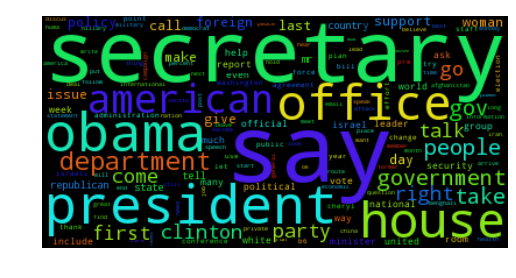

In [18]:
wordcloud = WordCloud(max_font_size=80).generate(joined_text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Exercise 2: World countries and Sentiment Analysis

### Task: 
The objective of this question is to find all mentions of world countries in all emails and to aggregate the polarity information of all emails by country

### Strategy:
We will start by constructing a mapping between each email and world countries and extract the most dominant country in the email.
Then, we will find the dominant sentiment in the email. 
1. Iterating over emails, finding countries occurences (using different forms) and building mappings between emails and countries => list of countries per each email
2. Trying different sentiment analysis demo methods of the emails
3. Aggregating sentiments of emails by country
4. Data Visualization

### 2.1. Countries Names: Normalization of different surface forms for the same country

In [19]:
emails_lemma_untagged = untag_lemma_emails(tagged_emails_without_normalized_lemma)

In [21]:
import pycountry
countries_mentions = []
for i in range(0,len(emails_lemma_untagged)):
    countries_mentions_sub = []
    print(i)
    for word in emails_lemma_untagged[i]:
        for country in pycountry.countries:
            if word == country.name.lower() or word == country.alpha_2.lower() or word == country.alpha_3.lower():
                countries_mentions_sub.append(country.name.lower())
    countries_mentions.append(countries_mentions_sub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [ ]:
#countries_mentions[0]

In [ ]:
#emails_lemma_untagged[0]

In [22]:
f = open("email_country_mappings.txt", "w")
for i in range(0,len(countries_mentions)):
    f.write(','.join(map(repr, countries_mentions[i])))
    f.write('\n')
f.close()

In [ ]:
countries_mappings = []
text_file = open("email_country_mappings.txt", "r")
lines = text_file.read().split('\n')
for i in range(0,len(lines)):
    countries_mappings_sub = []
    for j in range(0,len(lines[i])):
        countries_mappings_sub.append(lines[i].split(',')[j])
    countries_mappings.append(countries_mappings_sub)

## 2.2. Trying different sentiment analysis demo methods of the emails

### a. Joining the words in email to have one sentence string

In [23]:
sep = ' '
joined_emails = []
for email in emails_lemma_untagged:
    joined_emails.append(sep.join(email))

In [ ]:
#joined_emails[0]

### a. Trying with liu hu lexicon 

In [ ]:
#for email in joined_emails:
demo_liu_hu_lexicon_result = demo_liu_hu_lexicon(email[0])

### b. Trying with vader lexicon

In [ ]:
#for email in joined_emails:
vader_result = str(demo_vader_instance(email[0]))

In [ ]:
email_polarities = []
sid = SentimentIntensityAnalyzer()
for i in range(0,len(joined_emails)):
    #print i
    email_polarities.append(sid.polarity_scores(joined_emails[i])['compound'])

In [ ]:
f = open("email_polarities.txt", "w")
f.write(email_polarities)
f.close()

## 2.3. Aggregating sentiments of emails by country

In [ ]:
# Storing emotion polarity score for each country mentioned in each email 
countries_emotions_whole = []
for i in range(0,len(countries_mentions)):
    for j in range(0,len(countries_mentions[i])):
        countries_emotions_whole.append((countries_mentions[i][j],email_polarities[i]))

countries_emotions_whole_df = pd.DataFrame(countries_emotions_whole, columns=["Country", "Emotion"]) 
# Aggregating Countries by mean of emotion polarities:
countries_emotions_mean = countries_emotions_whole_df.groupby('Country').mean()
#countries_emotions_mean

In [ ]:
countries_emotions_whole_df.to_csv('countries_emotions_whole_df.csv',index=False,encoding="utf-8")

## 2.4. Data Visualization

In [ ]:
%matplotlib inline
import seaborn as sns
import pandas as pd


palette = sns.color_palette("RdBu", n_colors=len(countries_emotions_mean))
countries_emotions_mean.plot(kind='bar', figsize=(14,4), color= palette)

# Exercise 3: LDA Topic Modelling 

### Task: 
Our task in this exercise is to run topic modelling over the email corpus to map it to a set of different topics.

### Strategy:
1. Creation of large enough documents by concatenating individual emails by threads 
2. Construct corpus and dictionary of the emails
3. Training lda model and infering topic distributions on this corpus 
4. Try with different different number of topics and comparing / printing the topics: going over words per topic and evaluate heterogenity of the topics 

### 3.1. Creation of documents by concatenating individual emails by threads

In [24]:
from pandas import Series, DataFrame


def f(x):
     return Series(dict(MetadataSubject = x['MetadataSubject'].sum(),  
                        RawText = "%s" % ', '.join(x['RawText'])))
emails_subject_cluster = emails.groupby('MetadataSubject').apply(f)
#emails_subject_cluster

In [52]:
import re
clean_email_bodies = emails['ExtractedBodyText'].dropna()

print("Got cleaned email bodies")

#We won't need anything other than Letters
pattern = re.compile('[\W\d_]+')
tokenized = clean_email_bodies.apply(lambda x: nltk.word_tokenize(pattern.sub(' ', x).lower()))
print("Removed numbers and stuff and..")
print("Tokenized with NLTK")



Got cleaned email bodies
Removed numbers and stuff and..
Tokenized with NLTK


In [65]:
print(emails['ExtractedBodyText'].iloc[1])
print('---------------------------------------------------------------------')
print(emails['RawText'].iloc[1])


B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary
---------------------------------------------------------------------
UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739546
Date: 05/13/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.
RELEASE IN
PART B6
From:
Sent:
To:
Subject:
Attachments:
B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
CONFIDENTIAL
March 3, 2011
For: Hillary
From: Sid
Re: Syria aiding Qaddafi
This memo has two parts. Part one is the report that Syria is providing air support for Qaddafi. Part two is a note
to Cody from Lord David Owen, former UK foreign secretary on his views of an increasingly 

In [67]:
from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))

STOP_WORDS = STOP_WORDS.union(set(
    ['say','unclassified','call', 'know', 'would', 'get', 'time', 'work', 'like', 'today', 'see', 'morning', 'also', 'back', 'tomorrow', 'meeting', 'think', 'good', 'want', 'could', 'working', 'well', 'fyi','fw','make','go','case','doc','clintonemail','original','part','new','unclassified','no','f','date','state','to','from','sent','am','pm','subject','mailto','fw','send','message','call', 'know', 'would', 'get', 'time', 'work', 'like', 'today', 'see', 'morning', 'also','say','may','would','need','year','one', 'back', 'tomorrow', 'meeting', 'think', 'good', 'want', 'could', 'working', 'well']
))

stops_removed = tokenized.apply(lambda x: [word for word in x if word not in STOP_WORDS and len(word) > 1])

#mail_bodies_ready = nltk.Text(tokenized)
#print("Generated NLTK text format")




stops_removed[0:5]

1    [thursday, march, latest, syria, aiding, qaddafi, sid, hrc, memo, syria, aiding, libya, docx, hr...
2                                                                                                  [thx]
4    [hrod, com, friday, march, huma, abedin, latest, syria, aiding, qaddafi, sid, hrc, memo, syria, ...
5    [pis, print, hrod, clintonernailcom, wednesday, september, russorv, gov, meet, right, wing, extr...
7    [hrod, corn, friday, march, huma, abedin, latest, syria, aiding, qaddafi, sid, hrc, memo, syria,...
Name: ExtractedBodyText, dtype: object

### 3.2. Pre-processing of the clustered raw email texts

In [27]:
print(emails_subject_cluster.columns)
emails_subject_cluster = replace_contractions(emails_subject_cluster)
emails_cluster_normalized = term_normalization(emails_subject_cluster)
print(emails_cluster_normalized.columns)
email_bag_words_cluster = bag_of_word_representation(emails_cluster_normalized)
tagged_emails_cluster = pos_tagging(email_bag_words_cluster)
tagged_emails_without_cluster = punctuation_numbers_stopword_removal(tagged_emails_cluster)
tagged_emails_without_normalized_cluster = normalize_nava_tags(tagged_emails_without_cluster)
tagged_emails_without_normalized_lemma_cluster = lemmatizer(tagged_emails_without_normalized_cluster)

Index(['MetadataSubject', 'RawText'], dtype='object')
Index(['MetadataSubject', 'RawText'], dtype='object')


KeyError: 'ExtractedBodyText'

In [ ]:
emails_lemma_untag_cluster = untag_lemma_emails(tagged_emails_without_normalized_lemma_cluster)

In [ ]:
len(emails.iloc[3]['RawText'])

In [ ]:
#emails_lemma_untag_cluster[0]

### 3.3. Construct corpus and dictionary of the emails 

In [ ]:
from gensim import corpora, models, similarities
from gensim.models import hdpmodel, ldamodel
from itertools import izip

email_dictionary = corpora.Dictionary(emails_lemma_untag_cluster)
email_corpus = [email_dictionary.doc2bow(email) for email in emails_lemma_untag_cluster]

### 3.4. Training LDA model and infering topic distributions of the corpus

In [ ]:
lda = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=20)


### 3.4. Trying with different number of topics and Printing and Comparing the results

In [ ]:
lda_50 = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=50)

In [ ]:
corpus_lda_50 = lda_50[email_corpus]

#for l,t in izip(corpus_lda_50,email_corpus):
#    print l,"#",t

#for top in lda_50.print_topics(50):
#    print top

In [ ]:
lda_40 = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=40)
#for top in lda_40.print_topics(40):
#    print top

In [ ]:
lda_30 = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=30)
#for top in lda_30.print_topics(30):
#    print top

In [ ]:
lda_20 = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=20)
#for top in lda_20.print_topics(20):
#    print top

In [ ]:
lda_10 = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=10)
#for top in lda_10.print_topics(10):
#    print top

In [ ]:
lda_5 = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=5)
#for top in lda_5.print_topics(5):
#    print top

# Bonus Question:

### Task: 
Our task for this bonus question is to build the communication graph (unweighted and undirected) among the different email senders and recipients using the `NetworkX` library. 

### Strategy:
1. Build unweighted and undirected communication graph among email senders and recipients
2. Find communities in this graph with `community.best_partition(G)` method from the [community detection module](http://perso.crans.org/aynaud/communities/index.html). 
3. Print the most frequent 20 words used by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
4. Identify clear discussion topics for each community? Discuss briefly the obtained results.


### 4.1. Build Communication graph among email senders and recipients 

### a. Loading Receivers from csv File

In [ ]:
receivers= pd.read_csv('hillary-clinton-emails/EmailReceivers.csv')
receivers.columns=['Receiver_Id','EmailId','Receiver_PersonId']
receivers.head(3)

In [ ]:
receiver_emails=pd.merge(receivers,emails,left_on='EmailId', right_on='Id', how='inner')
receiver_emails=receiver_emails[['RawText','EmailId','SenderPersonId','Receiver_PersonId']]

In [ ]:
persons= pd.read_csv('hillary-clinton-emails/Persons.csv')

### b. Building the vertices and edges of the network

In [ ]:
net=receiver_emails[['SenderPersonId','Receiver_PersonId']]
net=net.dropna(axis=0)
net['SenderPersonId'] = net['SenderPersonId'].astype('int')
s=net['SenderPersonId'].unique().tolist() # getting the list of distinct senders
r=net['Receiver_PersonId'].unique().tolist() # getting the list of distinct receivers
all_users=s+r # concatenating senders and receivers
distinct_users=list(set(all_users)) # getting the list of distinct senders and receivers

### c. Building and Drawing the graph

In [ ]:
G=nx.Graph() # Initializing the graph 
for user in distinct_users:
    G.add_node(user)
net1=net.drop_duplicates(['SenderPersonId','Receiver_PersonId'])
net1.reset_index(inplace=True)
net1=net1.drop('index', axis=1)
def nodes_connected(u, v):
    return u in G.neighbors(v)


for index, row in net1.iterrows():
    s=row['SenderPersonId']
    r=row['Receiver_PersonId']
    if(not nodes_connected(s,r)):
        G.add_edge(s,r)

#first compute the best partition
partition=community.best_partition(G) # is a dictionary where keys are their users and values the communities the users belong to

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                               if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                               node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

In [ ]:
print "For:"+str(len(set(partition.keys())))+" authors, we have: "+str(len(set(partition.values())))+" communities"

In [ ]:
#partition 
author_community_map = pd.DataFrame.from_dict(partition, orient='index')
author_community_map.columns = ['Community']
author_community_map['Author'] = author_community_map.index

In [ ]:
grouped = author_community_map.groupby('Community')

community_authors = grouped.aggregate(lambda x: tuple(x))

community_authors['grouped'] = community_authors['Author']
community_authors = community_authors[['Author']]

In [ ]:
#community_authors

### 4.3. Print the most frequent 20 words used by the email authors of each community.

### a. Aggregate / Group by sender

In [ ]:
def f_from(x):
     return Series(dict(RawText = "%s" % ' '.join(x['RawText'])))
emails_cluster_from = receiver_emails.groupby('SenderPersonId').apply(f_from)
emails_cluster_from = emails_cluster_from.reset_index()
emails_cluster_from.columns = [['Author','RawText']]
emails_cluster_from.head()

In [ ]:
receiver_emails.columns

In [ ]:
len(emails_cluster_from)

In [ ]:
community_list = []
for i in range(0, len(emails_cluster_from)):
    community_list.append(partition.get(emails_cluster_from.iloc[i]['Author']))
emails_cluster_from['Community'] = community_list

In [ ]:
#emails_cluster_from

### b. Aggregate / Group by receiver

In [ ]:
def f_to(x):
     return Series(dict(RawText = "%s" % ' '.join(x['RawText'])))
emails_cluster_to = receiver_emails.groupby('Receiver_PersonId').apply(f_to)
emails_cluster_to = emails_cluster_to.reset_index()
emails_cluster_to.columns = [['Author','RawText']]
emails_cluster_to.head()

In [ ]:
len(emails_cluster_to)

### c. Concatenate the two aggregations

In [ ]:
concatenated_frames = [emails_cluster_from, emails_cluster_to]
concatenated_emails = pd.concat(concatenated_frames)

### d. Grouping by Author name:

In [ ]:
def f_author(x):
     return Series(dict(RawText = "%s" % ' '.join(x['RawText'])))
emails_cluster_author = concatenated_emails.groupby('Author').apply(f_author)
emails_cluster_author = emails_cluster_author.reset_index()
emails_cluster_author.columns = [['Author','RawText']]
emails_cluster_author.head()
len(emails_cluster_author)
#len(community_authors)

In [ ]:
community_list = []
for i in range(0, len(emails_cluster_author)):
    community_list.append(partition.get(emails_cluster_author.iloc[i]['Author']))
emails_cluster_author['Community'] = community_list

In [ ]:
len(set(emails_cluster_author['Author']))
#partition.values())
#emails_cluster_author['Community'] = partition.values()

In [ ]:
count = 0
for i in range(0,len(receiver_emails)):
    community_sender = partition.get(receiver_emails.iloc[i]['SenderPersonId'])
    community_receiver = partition.get(receiver_emails.iloc[i]['Receiver_PersonId'])
    if community_sender == community_receiver :
        count = count + 1
count / len(receiver_emails) * 100

### e. Pre-processing community_emails:

In [ ]:
emails_community_cluster = replace_contractions(emails_cluster_author)
emails_community_normalized = term_normalization(emails_community_cluster)
email_bag_words_community = bag_of_word_representation(emails_community_normalized)
tagged_emails_community = pos_tagging(email_bag_words_community)
tagged_emails_without_community = punctuation_numbers_stopword_removal(tagged_emails_community)
tagged_emails_without_normalized_community = normalize_nava_tags(tagged_emails_without_community)
tagged_emails_without_normalized_lemma_community = lemmatizer(tagged_emails_without_normalized_community)
emails_lemma_untag_community = untag_lemma_emails(tagged_emails_without_normalized_lemma_community)
email_bag_flat_community = flat_tag_bag_of_word_representation(tagged_emails_without_normalized_lemma_community)
sep = ' '
joined_text_community = sep.join(email_bag_flat_community)

### f. Find 20 most frequent words per each community

In [ ]:
most_frequent_words = []
for i in range(0,len(emails_lemma_untag_community)):
    most_frequent_words_sub = []
    word_counter = Counter(emails_lemma_untag_community[i]) #counts the number each time a word appears
    most_common_tuples = word_counter.most_common(20)
    for (word,frequency) in most_common_tuples:
        most_frequent_words_sub.append(word)
    most_frequent_words.append(most_frequent_words_sub)

In [ ]:
#most_frequent_words

### Do these word lists look similar to what you've produced at step 3 with LDA?